# 성능비교표
```
     Model	Accuracy	Recall (1)	ROC AUC
RandomForest	0.9247	0.8279	0.9680
XGBoost         0.9299	0.7090	0.9618
LSTM+CNN	    0.9459	0.4190	0.8976
Transformer	 0.9624	0.9413	0.9874


분석 요약
      모델	      Precision (1)	Recall (1)	F1-score (1)	ROC AUC
RandomForest	       0.5580	    0.8279     	0.6667     	0.9680
XGBoost	            0.5966    	0.7090	     0.6479     	0.9618
LSTM+CNN	           0.1933	    0.4190     	0.2645     	0.8976
Transformer            0.2219    	0.9413	     0.3591     	0.9874
```
```
 해석 요약
Transformer: 압도적 Recall과 ROC AUC로 침수 탐지에 가장 뛰어난 성능.

RandomForest: 좋은 Accuracy와 Recall 균형.

XGBoost: Accuracy 높고, 침수 탐지 능력은 중간 수준.

LSTM+CNN: Accuracy는 높지만 침수 탐지 성능은 낮음 (Recall 낮음).
```

```
목적                      	추천 모델	             이유
홍수 탐지 민감도 (recall)	RandomForest/XGBoost	실질적인 위험 탐지에 유리
정확도 + general 성능	    Transformer (SMOTE 적용)	높은 AUC와 Accuracy
실시간 예측 속도             RandomForest	         예측 빠름, 연산 적음
시계열 특화	              Transformer	           과거 시간 정보 반영
```

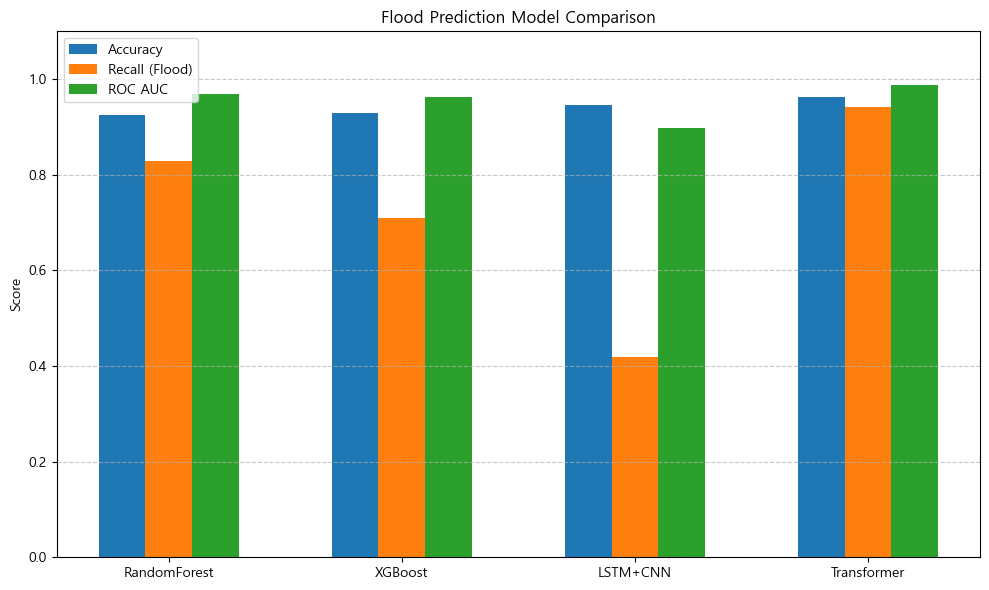

In [22]:
import matplotlib.pyplot as plt

# 모델 및 성능 지표
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9247, 0.9299, 0.9459, 0.9624]
recall = [0.8279, 0.7090, 0.4190, 0.9413]
roc_auc = [0.9680, 0.9618, 0.8976, 0.9874]

# 그래프 생성
plt.figure(figsize=(10, 6))
x = range(len(models))

# 막대 그래프 그리기
plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

# 라벨 및 설정
plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("Flood Prediction Model Comparison")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 파일 저장 및 출력
plt.savefig("model_comparison_updated.png")
plt.show()

# 한글설정, 워닝제거

In [16]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# smote 처리를 위한 라이브러리 설치

In [ ]:
pip install imbalanced-learn

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# Transformer ML
```
데이터 전처리 재사용 (X_seq.npy, y_seq.npy)

데이터 분할 (train/test)

Positional Encoding 정의

Transformer Encoder 기반 모델 정의 (Keras)

모델 학습 및 평가

시각화 (ROC Curve, Confusion Matrix 등)
```

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# 1. 슬라이딩 윈도우 데이터 불러오기
X_seq = np.load("X_seq.npy")
y_seq = np.load("y_seq.npy")

# 2. 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42)

# 3. Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        pos = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        i = tf.range(start=0, limit=tf.shape(x)[2], delta=1, dtype=tf.float32)  #  float32로 명시
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(tf.shape(x)[2], tf.float32))
        angle_rads = tf.cast(pos[:, tf.newaxis], tf.float32) * angle_rates
        angle_rads = tf.expand_dims(angle_rads, 0)  # (1, time, dim)
        angle_rads = tf.broadcast_to(angle_rads, tf.shape(x))  # (batch, time, dim)
        return x + angle_rads

# 4. Transformer 모델 정의
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding()(inputs)
    x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.1)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# 5. 모델 컴파일 및 학습
model = build_transformer_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
954/954 [==============================] - 15s 14ms/step - loss: 0.0134 - accuracy: 0.9990 - val_loss: 0.0083 - val_accuracy: 0.9989
Epoch 2/10
954/954 [==============================] - 14s 15ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.0086 - val_accuracy: 0.9989
Epoch 3/10
954/954 [==============================] - 13s 14ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0062 - val_accuracy: 0.9989
Epoch 4/10
954/954 [==============================] - 14s 14ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9989
Epoch 5/10
954/954 [==============================] - 14s 14ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0062 - val_accuracy: 0.9989
Epoch 6/10
954/954 [==============================] - 14s 14ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0063 - val_accuracy: 0.9989
Epoch 7/10
954/954 [==============================] - 13s 14ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0060 - val_accuracy:

In [5]:
# 테스트셋 예측
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 평가 지표 출력
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

2044/2044 [==============================] - 6s 3ms/step
Confusion Matrix:
 [[65318     0]
 [   65     0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995     65318
           1     0.0000    0.0000    0.0000        65

    accuracy                         0.9990     65383
   macro avg     0.4995    0.5000    0.4998     65383
weighted avg     0.9980    0.9990    0.9985     65383


ROC AUC Score: 0.9616597615923989


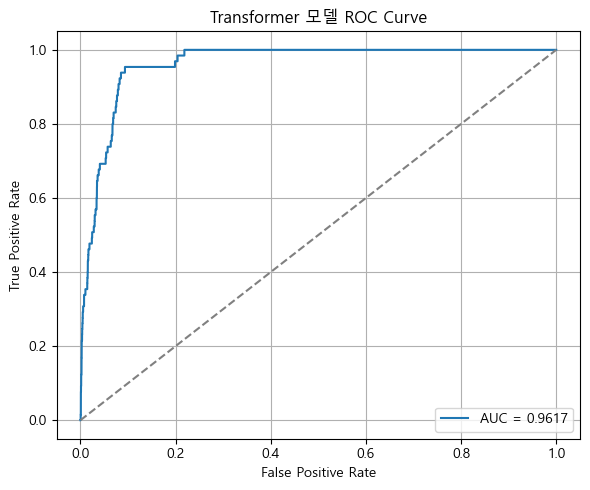

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Transformer 모델 ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Transformer 모델에 SMOTE 적용하고, 구조를 강화
- MultiHeadAttention 레이어를 스택으로 쌓음

```
SMOTE를 적용하려고 3D 시퀀스를 Flatten → Resample → 다시 Reshape

Transformer Block을 2개 이상 쌓아 표현력 강화

GlobalAveragePooling → Dense로 classification

EarlyStopping으로 과적합 방지
```

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 시퀀스 데이터 로딩
X = np.load("X_seq.npy")  # shape: (samples, 24, 10)
y = np.load("y_seq.npy")  # shape: (samples,)

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# 3. Flatten 후 SMOTE 적용 (주의: Flatten해서 oversample 후 다시 reshape)
X_flat = X_train.reshape((X_train.shape[0], -1))
smote = SMOTE(random_state=42)
X_flat_resampled, y_train_resampled = smote.fit_resample(X_flat, y_train)
X_train_resampled = X_flat_resampled.reshape((-1, 24, 10))

# 4. Positional Encoding 레이어 정의
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        d_model_float = tf.cast(d_model, tf.float32)

        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)

        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model_float)
        angle_rads = pos * angle_rates

        # sin to even indices; cos to odd indices
        sin_encoding = tf.math.sin(angle_rads[:, 0::2])
        cos_encoding = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sin_encoding, cos_encoding], axis=-1)

        # 혹시 짝수/홀수 불일치로 shape 안 맞을 때를 대비해 정렬
        pos_encoding = tf.reshape(pos_encoding, (1, seq_len, d_model))

        return x + pos_encoding

# 5. Transformer Block 정의
def transformer_block(x, num_heads, key_dim, ff_dim, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    x = Add()([x, ffn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# 6. 모델 구성
def build_transformer_model(input_shape, num_blocks=2):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding()(inputs)

    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=2, key_dim=32, ff_dim=64, dropout_rate=0.1)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(inputs, x)

# 7. 모델 학습
model = build_transformer_model((24, 10), num_blocks=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# 8. 평가
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_proba = model.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Epoch 1/10
1886/1886 [==============================] - 74s 38ms/step - loss: 0.2441 - accuracy: 0.8936 - val_loss: 0.2000 - val_accuracy: 0.9943
Epoch 2/10
1886/1886 [==============================] - 79s 42ms/step - loss: 0.1724 - accuracy: 0.9335 - val_loss: 0.1397 - val_accuracy: 0.9859
Epoch 3/10
1886/1886 [==============================] - 76s 40ms/step - loss: 0.1500 - accuracy: 0.9440 - val_loss: 0.1682 - val_accuracy: 0.9852
Epoch 4/10
1886/1886 [==============================] - 72s 38ms/step - loss: 0.1340 - accuracy: 0.9501 - val_loss: 0.0841 - val_accuracy: 0.9974
Epoch 5/10
1886/1886 [==============================] - 71s 38ms/step - loss: 0.1226 - accuracy: 0.9552 - val_loss: 0.1160 - val_accuracy: 0.9848
Epoch 6/10
1886/1886 [==============================] - 73s 39ms/step - loss: 0.1133 - accuracy: 0.9598 - val_loss: 0.0787 - val_accuracy: 0.9873
Epoch 7/10
1886/1886 [==============================] - 68s 36ms/step - loss: 0.1053 - accuracy: 0.9630 - val_loss: 0.0872 -

# Transformer
```
분석 요약
      모델	      Precision (1)	Recall (1)	F1-score (1)	ROC AUC
RandomForest	       0.5580	    0.8279     	0.6667     	0.9680
XGBoost	            0.5966    	0.7090	     0.6479     	0.9618
LSTM+CNN	           0.1933	    0.4190     	0.2645     	0.8976
Transformer            0.2219    	0.9413	     0.3591     	0.9874
```

# 시각화

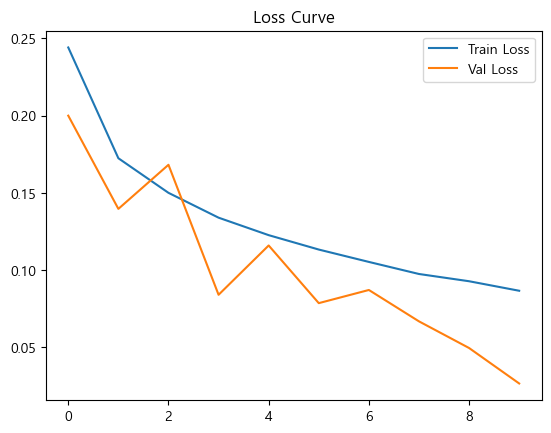

In [18]:
# 9. 학습 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

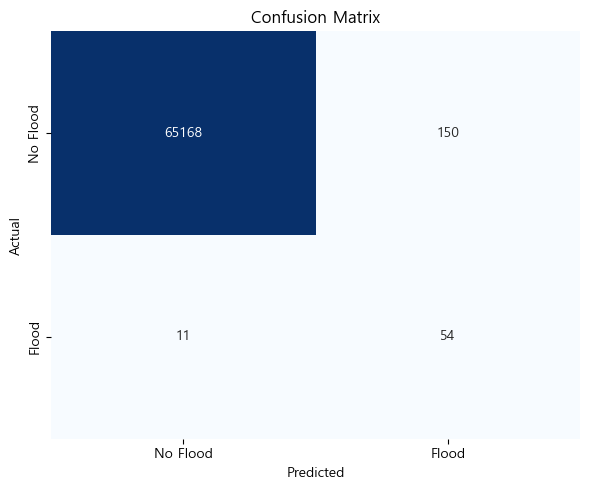

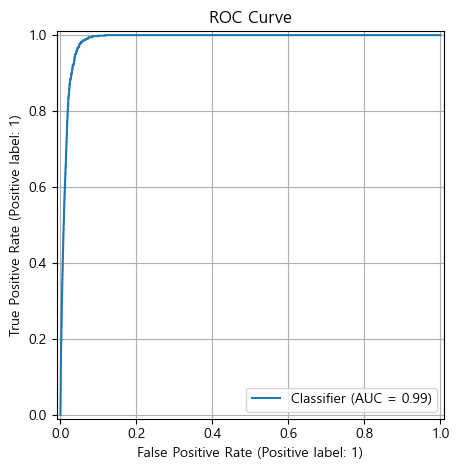

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

#  Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Flood", "Flood"],
            yticklabels=["No Flood", "Flood"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

#  ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()


# 모델 저장하기

In [20]:
model.save("transformer_flood_model.h5")

# 리포트 저장하기

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# 리포트 생성
report = classification_report(y_test, y_pred, digits=4)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# 텍스트 파일로 저장
with open("transformer_report.txt", "w", encoding="utf-8") as f:
    f.write(" Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write(" Classification Report:\n")
    f.write(report + "\n")
    f.write(f" ROC AUC Score: {auc:.4f}\n")

print(" 리포트가 'transformer_report.txt'로 저장되었습니다.")


 리포트가 'transformer_report.txt'로 저장되었습니다.
